In [264]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt

In [265]:
#using the urbansound8k dataset for training our ML Model
#There is 8732 samples
data_dir = "/kaggle/input/"
df = pd.read_csv(os.path.join(data_dir, "UrbanSound8K.csv"))
df['relative_path'] = data_dir + '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)
df.head(2)

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   

              class                            relative_path  
0          dog_bark    /kaggle/input//fold5/100032-3-0-0.wav  
1  children_playing  /kaggle/input//fold5/100263-2-0-117.wav

# preprocessing data

In [266]:
from concurrent.futures import ThreadPoolExecutor
from scipy.interpolate import interp1d
from scipy.ndimage import zoom

def padding(array, xx, yy):
    h = array.shape[0]
    w = array.shape[1]

    a = max((xx-h)//2 ,0 )
    aa = max(0, (xx-a-h))

    b = max(0, (yy-w)//2)
    bb = max(yy-b-w, 0)

    return np.pad(array, pad_width=((a,aa), (b,bb)), mode='constant')

def nulldata_remove(wav: np.ndarray, threshold: int) -> np.ndarray:
  wav =np.abs(wav)
  mask = wav > threshold

  return mask
def normalize_data_linearly(data_features):
    #When the feature is more-or-less uniformly distributed across a fixed range.
    return (data_features - np.min(data_features))/(np.max(data_features) - np.min(data_features))

def normalize_data_zScore(data_features):
    #When the feature distribution does not contain extreme outliers.
    return (data_features - np.mean(data_features))/(np.std(data_features))

def preprocess(row, target_sr=16000):
    # Lets Load, resample, and remove any NULL data
    audio, orig_sr = librosa.load(row['relative_path'])

    #Resample the audio sample to 16000(This wiil significantly reduce the number of features)
    audio= librosa.resample(audio, orig_sr=orig_sr, target_sr=target_sr)

    sound_mask = nulldata_remove(audio, 0.005)
    audio_denoised = audio[sound_mask]

    target_audio_length = 30000
    if len(audio_denoised) >= target_audio_length:
        #just save the first 30000 features
        #If over 30000 then it means that the data is mostly noise and we need to reduce the
        #Number of features for model training
        audio_denoised = audio_denoised[:target_audio_length]
    if len(audio_denoised) < target_audio_length and len(audio_denoised) != 0 :
        padding_needed = target_audio_length - len(audio_denoised)
        audio_denoised = np.pad(audio_denoised, (0, padding_needed), mode='constant', constant_values=0)

    if len(audio_denoised) > 0:
        stft = np.abs(librosa.stft(y=audio_denoised, n_fft=1024, hop_length=1024))
        stft = librosa.amplitude_to_db(stft, ref=np.max)
        stft = normalize_data_zScore(stft)
        rmse = librosa.feature.rms(y=audio_denoised)
        rmse = rmse.T
        rmse = normalize_data_linearly(rmse)
        mfcc = librosa.feature.mfcc(y=audio_denoised, n_mfcc=64)
        mfcc = normalize_data_zScore(mfcc)
        if len(rmse[:,0]) > 1:

            target_shape = (64,64)

            stft =padding(stft, target_shape[0], target_shape[1])
            mfcc = padding(mfcc,  target_shape[0], target_shape[1])
            rmse = padding(rmse,  target_shape[0], target_shape[1])

            stft_zoom_levels = np.array(target_shape) / np.array(stft.shape)
            stft_resized = zoom(stft, stft_zoom_levels, order=1)

            image = np.stack([rmse, mfcc, stft_resized],axis=-1)

            images.append(image)
            labels.append(row['class'])
            fileName.append(row['relative_path'])


            lengths.append(len(audio_denoised))
            stft_feature_lengths.append(stft.shape)
            rmse_feature_lengths.append(rmse.shape)
            mfcc_feature_lengths.append(mfcc.shape)


pool_size=10

lengths = []
fileName=[]
stft_feature_lengths = []
rmse_feature_lengths = []
mfcc_feature_lengths = []
images = []
labels = []
with ThreadPoolExecutor(max_workers=pool_size) as pool:
    try:
        for i, row in df.iterrows():
            pool.submit(preprocess, row)
    except Exception as e:
        print(e)

print("ThreadPool Finished!")

# lengths = []
# stft_feature_lengths = []
# rmse_feature_lengths = []
# mfcc_feature_lengths = []
# images = []
# labels = []
# for i, row in df.iterrows():
#     preprocess(row)
# print('Done')


ThreadPool Finished!


In [267]:
print(images[0].shape)
num_images = len(images)

(64, 64, 3)


[1175, 8359, 8380]


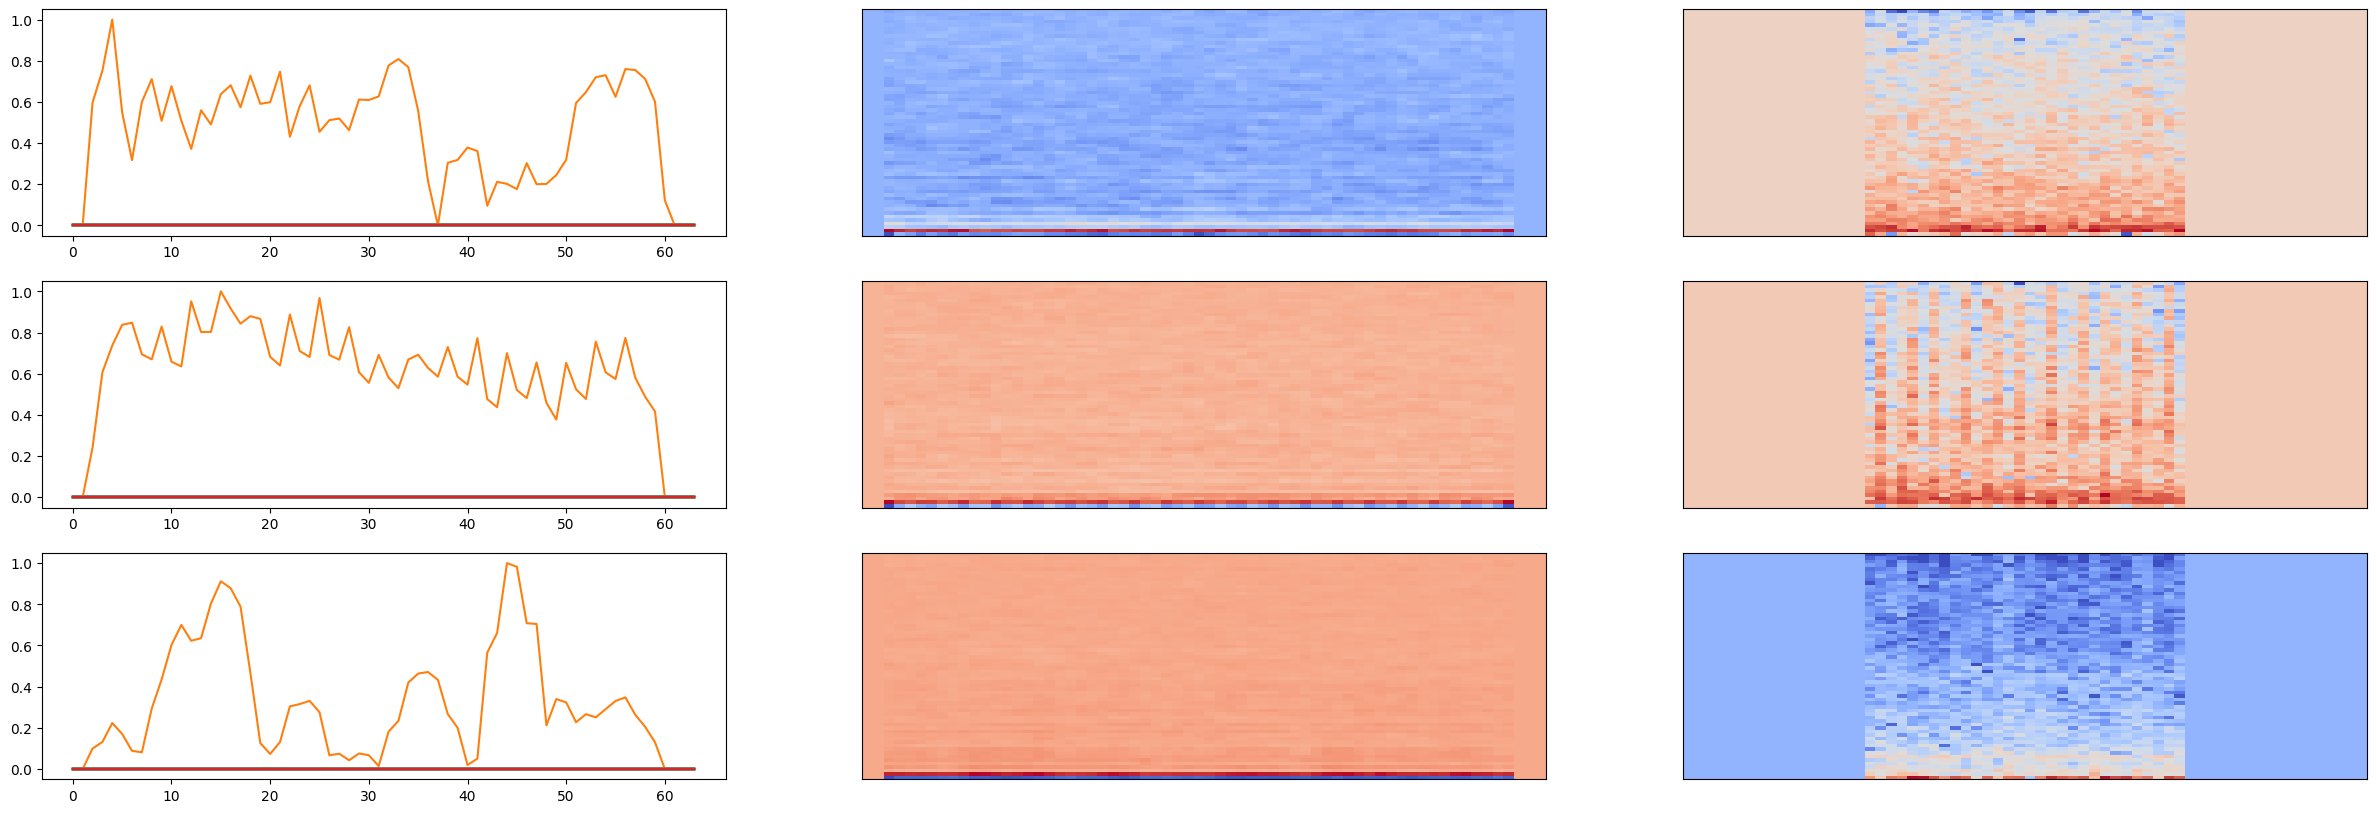

In [268]:
import random
index = [ random.randint(0,num_images) for _ in range(3)]
print(index)
fig ,ax = plt.subplots(3,3, figsize=(30,10))

ax[0,0].plot(images[index[0]][:,:,0])
librosa.display.specshow(images[index[0]][:,:,1], ax=ax[0,1])
librosa.display.specshow(images[index[0]][:,:,2], ax=ax[0,2])

ax[1,0].plot(images[index[1]][:,:,0])
librosa.display.specshow(images[index[1]][:,:,1], ax=ax[1,1])
librosa.display.specshow(images[index[1]][:,:,2], ax=ax[1,2])

ax[2,0].plot(images[index[2]][:,:,0])
librosa.display.specshow(images[index[2]][:,:,1], ax=ax[2,1])
librosa.display.specshow(images[index[2]][:,:,2], ax=ax[2,2])


plt.show()

In [269]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Encode Classes
encoder = LabelEncoder()
y=encoder.fit_transform(labels)
labels=to_categorical(y, num_classes=10)

In [270]:
import pandas as pd
df=pd.DataFrame({
    'images':images,
    'fileName':fileName
})

In [271]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, labels,test_size=0.05, stratify=labels, random_state=42)

#Split the training set again for validation set
X_train,X_val, y_train, y_val= train_test_split(X_train,y_train, test_size=0.10, random_state=42)

print(len(X_train), len(X_test), len(X_val))
print(len(y_train), len(y_test), len(y_val))


7441 436 827
7441 436 827


In [272]:
X_test_temp=X_test

In [273]:
df.head()

images  \
0  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, -1.9...   
1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, -3.8...   
2  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, -4.2...   
3  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, -2.7...   
4  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, -3.1...   

                                  fileName  
0    /kaggle/input//fold5/100032-3-0-0.wav  
1  /kaggle/input//fold5/100263-2-0-126.wav  
2  /kaggle/input//fold5/100263-2-0-143.wav  
3   /kaggle/input//fold10/100648-1-0-0.wav  
4  /kaggle/input//fold5/100263-2-0-161.wav

In [274]:
df['images'][0].shape

(64, 64, 3)

In [275]:
X_train = np.array(X_train.images.to_list())
X_val = np.array(X_val.images.to_list())
X_test = np.array(X_test.images.to_list())

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(len(X_train), len(X_test), len(X_val))
print(len(y_train), len(y_test), len(y_val))

7441 436 827
7441 436 827


In [276]:
from tensorflow.keras import Sequential, layers, optimizers, regularizers
from tensorflow import keras

INPUT_SHAPE= (64,64,3)

model =Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [277]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,002 (2.64 MB)

 Trainable params: 692,554 (2.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [278]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta = 5e-4,
                               patience=5,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr = 1e-5
)

In [279]:
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[early_stopping, reduce_lr],
                    batch_size=32)


Epoch 1/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.1198 - loss: 5.6345 - val_accuracy: 0.1850 - val_loss: 3.8433 - learning_rate: 0.0010
Epoch 2/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1303 - loss: 3.1889 - val_accuracy: 0.2467 - val_loss: 2.5444 - learning_rate: 0.0010
Epoch 3/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1858 - loss: 2.4976 - val_accuracy: 0.2636 - val_loss: 2.2108 - learning_rate: 0.0010
Epoch 4/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2268 - loss: 2.2732 - val_accuracy: 0.3132 - val_loss: 2.0368 - learning_rate: 0.0010
Epoch 5/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2617 - loss: 2.1684 - val_accuracy: 0.3482 - val_loss: 1.8947 - learning_rate: 0.0010
Epoch 6/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3196 - loss: 2.0621 - val_accuracy: 0.5042 - val_loss: 1.8473 - learning_rate: 0.0010
Epoch 7/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3882 - loss: 

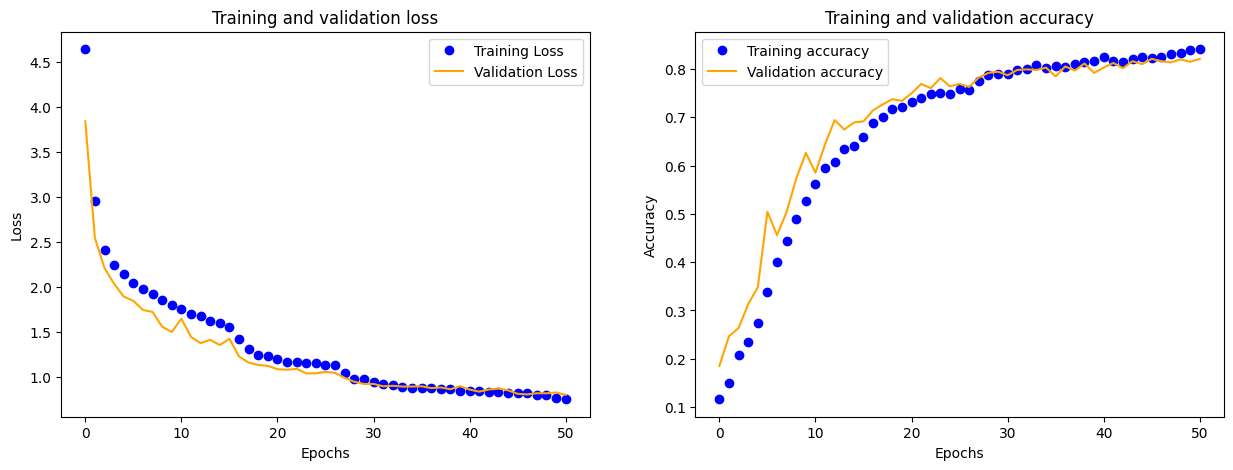

In [280]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
len_epochs = int(early_stopping.stopped_epoch) + 1
epochs=range(0,len_epochs)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

# Saving Model

In [281]:
model.save('/kaggle/working/soundClassifier.h5')


# Prediction on Test Data

In [282]:
class_mapping = dict(zip(encoder.classes_,encoder.transform(encoder.classes_)))

classes=[]
for class_name, encoded_label in class_mapping.items():
    classes.append(class_name)
    
print("classes name and their encoding as index")
print(classes)

classes name and their encoding as index
['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [283]:
result=model.predict(X_test)

score=np.argmax(result,axis=1)

print(result.shape)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
(436, 10)


In [289]:


X_test_temp.reset_index(inplace=True)
# y_test=np.argmax(y_test,axis=0)
y_test_actual=np.argmax(y_test,axis=1)
y_test_actual[0]
predicted_classes=[]
actual_classes=[]

for i in range(len(y_test)):
    predicted_classes.append(classes[y_test_actual[i]])
    actual_classes.append(classes[score[i]])

predicted_classes=np.array(predicted_classes)
actual_classes=np.array(actual_classes)


In [290]:
import pandas as pd
final_result=pd.DataFrame({
    'fileName':X_test_temp.fileName,
    'actual_label':y_test_actual,
    'predicted_label':score,
    'actual_Class':actual_classes,
    'predicted_Class':predicted_classes
})

# Save to a specific path
final_result.to_csv('/kaggle/working/finalResult.csv', index=False)

final_result

fileName  actual_label  predicted_label  \
0    /kaggle/input//fold1/134717-0-0-18.wav             0                0   
1     /kaggle/input//fold7/157940-9-0-0.wav             9                9   
2    /kaggle/input//fold5/204408-2-0-21.wav             2                2   
3     /kaggle/input//fold3/17973-2-0-21.wav             2                2   
4     /kaggle/input//fold3/22601-8-0-51.wav             8                8   
..                                      ...           ...              ...   
431  /kaggle/input//fold3/185373-9-0-21.wav             9                9   
432   /kaggle/input//fold9/105029-7-1-8.wav             7                7   
433   /kaggle/input//fold6/94632-5-0-25.wav             5                5   
434   /kaggle/input//fold4/151005-4-1-2.wav             4                4   
435   /kaggle/input//fold2/177592-5-0-9.wav             5                2   

         actual_Class   predicted_Class  
0     air_conditioner   air_conditioner  
1        street_music      street_music  
2    children_playing  children_playing  
3    children_playing  children_playing  
4               siren             siren  
..                ...               ...  
431      street_music      street_music  
432        jackhammer        jackhammer  
433     engine_idling     engine_idling  
434          drilling          drilling  
435  children_playing     engine_idling  

[436 rows x 5 columns]

In [291]:
from sklearn.metrics import accuracy_score
val=accuracy_score(final_result.actual_label,final_result.predicted_label)
print("accuracy on test Dataset:", val)

accuracy on test Dataset: 0.8348623853211009


In [292]:
import IPython.display as ipd
for i in range(10):
    
    # Load the audio file using librosa
    audio, sr = librosa.load(final_result.fileName[i], sr=None)

    # Display the audio player
    ipd.display(ipd.Audio(data=audio, rate=sr))
    # Print the actual and predicted classes
    print(f"Sample {i+1}:")
    print(f"Actual Class: {classes[final_result.actual_label[i]]}")
    print(f"Predicted Class: {classes[final_result.predicted_label[i]]}")
    
    
    
    
    print("\n")  # Newline for better readability

Sample 1:
Actual Class: air_conditioner
Predicted Class: air_conditioner




Sample 2:
Actual Class: street_music
Predicted Class: street_music




Sample 3:
Actual Class: children_playing
Predicted Class: children_playing




Sample 4:
Actual Class: children_playing
Predicted Class: children_playing




Sample 5:
Actual Class: siren
Predicted Class: siren




Sample 6:
Actual Class: engine_idling
Predicted Class: engine_idling




Sample 7:
Actual Class: jackhammer
Predicted Class: jackhammer




Sample 8:
Actual Class: dog_bark
Predicted Class: dog_bark




Sample 9:
Actual Class: street_music
Predicted Class: street_music




Sample 10:
Actual Class: jackhammer
Predicted Class: jackhammer


